In [1]:

import tensorflow as tf
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
from data.utils import restore_pinn_model, plot_test
from data.utils import plot_states_BCS, plot_u
from data.parameters import Parameters
# from data.TrainingReport import TrainingReport
from data.PinnPredictor import PinnPredictor
with open("dataset_opera.pk", 'rb') as open_file:
    ds = pickle.load(open_file)
predictor=PinnPredictor("data_model02")
BCS_parameters=Parameters()

Loading model from data_model02


<Figure size 1440x288 with 0 Axes>

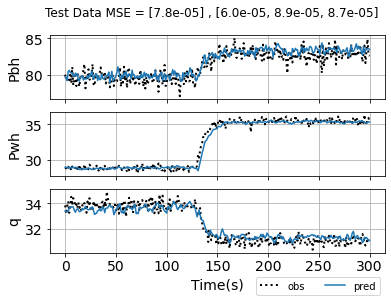

In [2]:
def free_predict(tstart,nsim,ds,model):
    X=ds.train_X[tstart:tstart+1,:,:]
    y=ds.train_y_full[tstart:tstart+nsim+1,:,:]
    u=ds.train_X[tstart:tstart+nsim+1,:,:]
    U=ds.train_X[tstart:tstart+nsim+1,:,:4]
    Xx=X[:,:,-2:]
    X0=X
    y0=model(X0)[:,0:1,:]
    pred=y0
    for i in range(nsim):
        Xx=tf.concat([Xx[:,1:,:],y0[:,:,:-1]],1) # Remove o instante mais antigo e atualiza o vetor de estados com a nova predição (remove q) 
        #print(U[i:i+1,:,:].shape)
        X0=tf.concat([U[i:i+1,:,:],Xx],2) # Remonta o vetor de entrada da rede (exógenas+saidas)
        y0=model(X0)[:,0:1,:]
        pred=tf.concat([pred,y0[:,0:1,:]],0)
    return pred,y,u
    
tstart=0
nsim=300


pred, yreal, ureal=free_predict(tstart,nsim,ds,predictor.model)
#np.square(yreal[:,0,2]- pred[:,0,2])
FigFree=plot_test(yreal, pred,[ds.parameters.xc,ds.parameters.x0])

plt.show()  # Uncomment to see the graphics



In [3]:
#Initial conditions
xi=np.array([7.92750470e+06, 2.90972936e+06], ndmin=2) #bar
ui=np.array([4.95914975e+01, 5.00190605e+01, 1.99149787e+06, 1.18634314e+07],ndmin=2) #Hz, 0-100%, bar,bar
#----------------------------------------------------------------
# Normalizar
xi=BCS_parameters.normalizar_x(xi)
#xi=[xi[0,0],xi[0,1]]

ui=BCS_parameters.normalizar_u(ui)
Xi=tf.convert_to_tensor(np.repeat([xi],20,axis=1), dtype=tf.float32)# Replicate to build NN input
Ui=tf.convert_to_tensor(np.repeat([ui],20,axis=1), dtype=tf.float32) # Replicate to build NN input

(TensorShape([1, 20, 2]), TensorShape([1, 20, 4]))

In [5]:
nsim=800
y0=predictor.model(tf.concat([Ui,Xi],2))
pred=y0
pred
nsim=300
y0=predictor.model(tf.concat([Xi,Ui],2))
predict=y0
nsteps=ds.n_steps_in
for i in range(nsim):
        Xi=tf.concat([Xi[:,1:,:],y0[:,:,:-1]],1) # Remove older time-step and update states vector with new predictions (remove q)
        Ui=tf.concat([Ui[:,1:,:],np.array([ds.un[nsteps+i:nsteps+i+1,:]])],1) # Remove older time-step and update exogenous vector with the next time-step
        y0=predictor.model(tf.concat([Ui,Xi],2)) # Compute the next prediction
        predict=tf.concat([predict,y0],0) # Store 
        
predict=predict.numpy()

ti=0;to=ti+nsim+1;


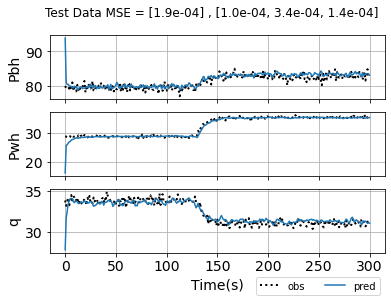

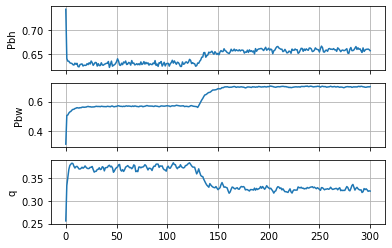

<Figure size 1440x288 with 0 Axes>

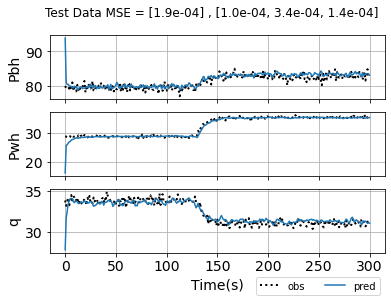

In [6]:
y=ds.train_y_full[ti:to,:,:]
u=ds.train_X[ti:to,0,:4]
t=np.arange(0,nsim+1,1)

plot_states_BCS(predict[:,0,:],t,norm=1)
plot_test(y, predict,[BCS_parameters.xc,BCS_parameters.x0])


{'un': <Figure size 432x288 with 4 Axes>,
 'xn': <Figure size 432x288 with 3 Axes>,
 'u': <Figure size 432x288 with 4 Axes>,
 'x': <Figure size 432x288 with 3 Axes>}

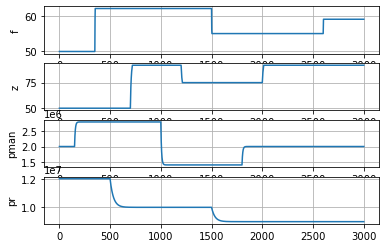

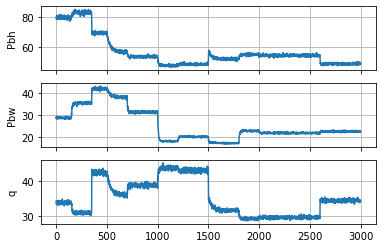

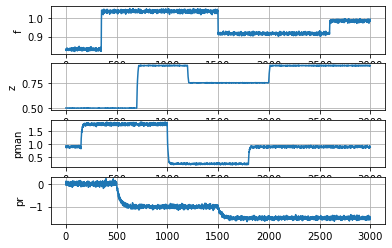

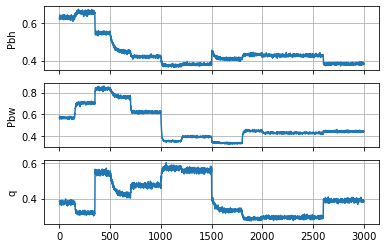

In [7]:
ds.gen_fig()

In [8]:
predictor.model(ds.train_X[0:10,:,:])[:,0,:]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0.6295054 , 0.5700462 , 0.3675545 ],
       [0.625999  , 0.56752455, 0.36568904],
       [0.6356712 , 0.56655097, 0.36619234],
       [0.63615644, 0.568665  , 0.3732924 ],
       [0.6334755 , 0.569486  , 0.37658834],
       [0.632972  , 0.5661124 , 0.3769198 ],
       [0.6330338 , 0.5702152 , 0.37741458],
       [0.6295533 , 0.56796724, 0.37750214],
       [0.6305952 , 0.56688875, 0.36997706],
       [0.63245434, 0.5678842 , 0.36765677]], dtype=float32)>

In [9]:
ds.train_y_full[0:10,0,:]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0.6321168 , 0.5690976 , 0.37650216],
       [0.6267368 , 0.5665713 , 0.3631681 ],
       [0.62931067, 0.5640222 , 0.37454903],
       [0.62943465, 0.5714661 , 0.38288027],
       [0.6259893 , 0.5647182 , 0.3647735 ],
       [0.6319763 , 0.56942004, 0.37393418],
       [0.6227075 , 0.56028956, 0.39003035],
       [0.6404771 , 0.5722404 , 0.37657392],
       [0.6204137 , 0.5665046 , 0.38793945],
       [0.6335362 , 0.56645477, 0.3840063 ]], dtype=float32)>

In [10]:
predict[0:10,0,:]


array([[0.7428766 , 0.30886072, 0.2558667 ],
       [0.64116853, 0.5051024 , 0.33293664],
       [0.63580126, 0.50806165, 0.35071874],
       [0.6357599 , 0.5213818 , 0.36812806],
       [0.632402  , 0.5288966 , 0.37690628],
       [0.6315867 , 0.5329138 , 0.37974817],
       [0.63111836, 0.54125273, 0.38181233],
       [0.6285905 , 0.5462243 , 0.3810013 ],
       [0.62774175, 0.5471838 , 0.37519664],
       [0.631648  , 0.5522827 , 0.37121993]], dtype=float32)

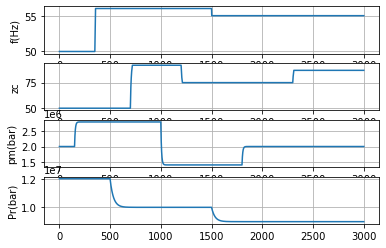

In [11]:
#Valores iniciais de simulação
tss=5 # Tempo inicial no estacionário
ts=1
pi=3.14159
npv=3
nmv=2
nde=2
tsim = 50*60; 
nsim=int(round(tsim/ts)+1)
#xss_n=xssn

Yk = np.zeros((npv,1))
Uk = np.zeros((nmv+nde,1))
Ymk = Yk
Ys = Yk
Ymin = Yk
Ymax = Yk

# fill vector x 
def lpf(x, omega_c, T):
    """Implement a first-order low-pass filter. 
    The input data is x, the filter's cutoff frequency is omega_c 
    [rad/s] and the sample time is T [s].  The output is y.
    """
    N=x.shape[0]
    y = x
    alpha = (2-T*omega_c)/(2+T*omega_c)
    beta = T*omega_c/(2+T*omega_c)
    for k in range(1, N):
        y[k] = alpha*y[k-1] + beta*(x[k]+x[k-1])
    return y

def step_function(tsim):
    x=np.arange(0,tsim)
    val_pm=[20e5,28e5,14e5,20e5]
    val_z=[50,100,75,95]
    val_f=[50,63,55,60]
    val_pr=[1.2e7,1e7,0.9e7]
    list_f=[(x >= 0) & (x<350), (x >= 350) & (x < 1500),(x >= 1500) & (x < 2600), x>=2600]
    list_z=[(x >= 0) & (x<700), (x >= 700) & (x < 1200), (x >= 1200) & (x < 2300),x>=2300]
    list_pm=[(x >= 0) & (x<150),  (x >=150) & (x<1000),(x >= 1000) & (x < 1800), x>=1800]
    list_pr=[(x >= 0) & (x<500),  (x >= 500) & (x < 1500), x>=1500]
    pm=np.piecewise(x,list_pm,val_pm)
    fk=np.piecewise(x,list_f, val_f)
    zc=np.piecewise(x,list_z, val_z)
    pr_z=np.piecewise(x,list_pr, val_pr)

    # Wn=2*pi*1/25
    # Wn2=2*pi*1/100    
    Wn=2*pi*0.05
    Wn2=2*pi*0.01
    pm_f=lpf(pm,Wn,1)
    pr_f=lpf(pr_z,Wn2,1)
    return np.array([lpf(fk,Wn,1),lpf(zc,Wn2*4,1),pm_f,pr_f])

label = ['f(Hz)',"zc", "pm(bar)", "Pr(bar)"];
f,zc,pm,pr=step_function(tsim)
entradas=[f,zc,pm,pr]
fig2=plt.figure()
for i,str in enumerate(label):
    ax=fig2.add_subplot(len(label),1,i+1)
    ax.plot(entradas[i].T, label='Medição')
    ax.set_ylabel(str)
    plt.grid(True)


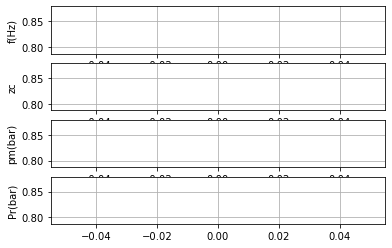

In [12]:
norm_inputs=[]
norm_inputs=predictor.norm_u(entradas)
fig2=plt.figure()    
entradas=norm_inputs
for i,str in enumerate(label):
    ax=fig2.add_subplot(len(label),1,i+1)
    ax.plot(entradas[i].T, label='Medição')
    ax.set_ylabel(str)
    plt.grid(True)

(3000, 3)


(3000,)

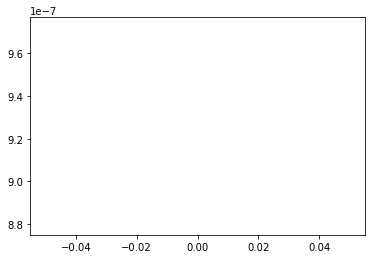

In [13]:
plt.plot((entradas[2]-ds.parameters.u0[0])/ds.parameters.uc[2])
print(ds.x.shape)
f.shape

In [14]:
predictor.norm_u(entradas)


IndexError: list index out of range

In [ ]:
#Initial conditions
xi=[10466565.75 ,  2546688.433] #bar
ui=[5.32846998e+01, 1.96547200e+00, 1.75045886e+06, 1.31403633e+07] #Hz, 0-100%, bar,bar
X0=xi+ui # join u with x
X0=np.array([[X0]*20]) # Replicate to build NN input
X0=tf.convert_to_tensor(X0, dtype=tf.float32) # convert_to_tensor



    

predictor.model.predict(X0) # model output